In [2]:
import pathlib
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import h5py
import pandas as pd
import json
import numpy as np
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
import dask.array as da
import skimage 

import SessionTools as st 
import SessionTools.two_photon

%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [3]:
basedir = pathlib.PurePath('/media/mplitt/SSD_storage/2PData/12_16_2022/EPG_GCaMP7f_CsChrimsontdT_fly1/fixed_cw_remapping-000/')
session = "fixed_cw_remapping-000"
basename_input = pathlib.Path(basedir.joinpath(session))
metadata = st.two_photon.metadata.read(basename_input)

h5name = '/media/mplitt/SSD_storage/2P_scratch/test.h5'
if not exists(h5name):
    tiff_data = st.two_photon.tiff_tools.read(basename_input, 
                                            metadata['size'],metadata['layout'])
    st.two_photon.tiff_tools.convert_to_hdf5(tiff_data,'/media/mplitt/SSD_storage/2P_scratch/test.h5', overwrite=True)

In [4]:
f = h5py.File(h5name)
data = f['/data']
# data = da.from_array(f['/data'], chunks = (2,1000,*f['/data'].shape[-3:]))

In [5]:
data.shape

(2, 3280, 7, 208, 259)

In [6]:
metadata['size']

{'frames': 3280,
 'channels': 2,
 'z_planes': 7,
 'y_px': 208,
 'x_px': None,
 'x_pix': 259}

In [7]:
ref_channel = 0

ref_intervals = np.arange(0,data.shape[1],round(data.shape[1]/10)).tolist()
ref_frames = []
for frame in ref_intervals:
    for i in range(20):
        ref_frames.append(frame+i)
ref_img = skimage.img_as_float(data[ref_channel, ref_frames,:,:,:].mean(axis=0))


In [9]:
from skimage.registration import phase_cross_correlation
from joblib import Parallel, delayed
from scipy.ndimage import shift as spshift

n_frames = metadata['size']['frames']
n_zplanes = metadata['size']['z_planes']
n_ch = metadata['size']['channels']
shift = np.zeros((2, n_frames, n_zplanes))
error = np.zeros((n_frames, n_zplanes))
diffphase = np.zeros((n_frames, n_zplanes))

chunk_size = int(np.minimum(4000,n_frames))
data_chunk = data[:,:chunk_size,:,:,:]
def compute_shift(f,z):
    frame = skimage.img_as_float(data_chunk[ref_channel, f, z, :, :])
    with st.utilities.suppress_output(suppress_stderr=True):
        shift[:, f,z], error[f,z], diffphase[f,z] = phase_cross_correlation(ref_img[z, :, :], frame, upsample_factor = 10, space= 'fourier')
    shifts = [spshift(data_chunk[ch,f,z,:,:], shift[:,f,z], order = 1, mode='reflect') for ch in range(n_ch)]
    return (f,z, shifts)
    
# align_z_stack(0,0)
results = Parallel(n_jobs = -1)(delayed(compute_shift)(f,z) for f in range(chunk_size) for z in range(n_zplanes))

for (f,z,shifts) in results:
    data_chunk[0,f,z,:,:] = shifts[0]
    data_chunk[1,f,z,:,:] = shifts[1]
# corr_data = np.copy(data_chunk)
# for f in range(chunk_size):
#     for z in range(n_zplanes):
#         for ch in range(n_ch):
#             corr_data[ch,f,z,:,:] = spshift(data_chunk[ch,f,z,:,:], shift[:,f,z], order = 1, mode='reflect')


# for f in range(n_frames):
#     if f%100==0: print(f)
#     for z in range(n_zplanes):
#         frame = skimage.img_as_float(data[ref_channel, f, z, :, :])
#         shift[:, f,z], error[f,z], diffphase[f,z] = phase_cross_correlation(ref_img[0, :, :], frame, upsample_factor = 10, space= 'fourier')

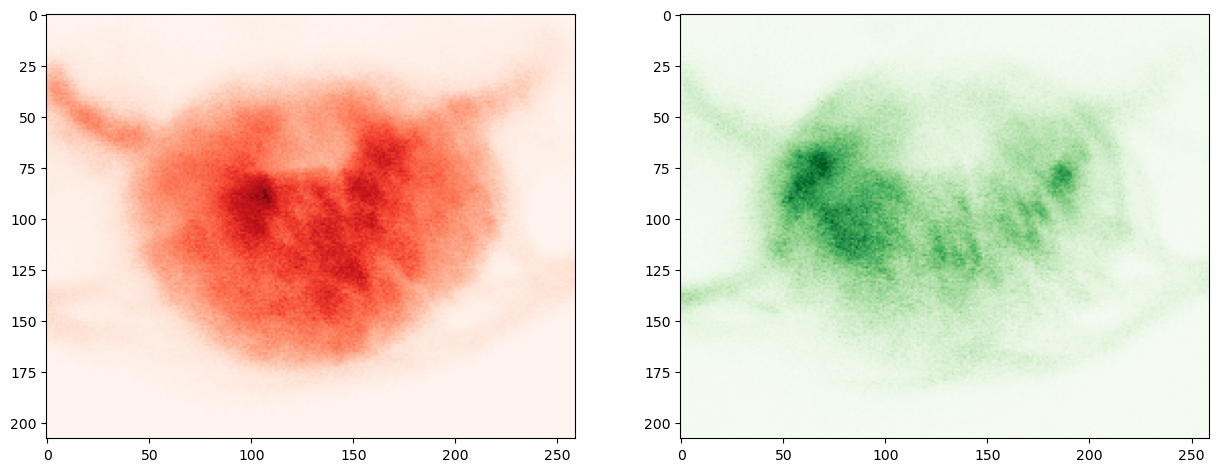

In [18]:
# for z in range(n_zplanes):
#     fig, ax = plt.subplots()
#     ax.imshow(data_chunk[1,:,z,:,:].mean(axis=0),cmap='magma')
    
fig,ax = plt.subplots(1,2,figsize=[15,8])
ax[0].imshow(np.amax(data_chunk[0,:,2:,:,:].mean(axis=0),axis=0),cmap='Reds')
ax[1].imshow(np.amax(data_chunk[1,:,2:,:,:].mean(axis=0),axis=0),cmap='Greens')

In [9]:


def shift_one_image(block_id):
    frame = skimage.img_as_float(data[ref_channel, block_id[0], block_id[1], :, :])
    shift[:, block_id[0],block_id[1]], error[block_id[0],block_id[1]], diffphase[block_id[1],block_id[2]] = phase_cross_correlation(ref_img[0, :, :], frame, upsample_factor = 10, space= 'fourier')
    ch1 = spshift(data[0,block_id[0],block_id[1],:,:],
                          shift[:,block_id[0],block_id[1]], 
                          order=1, mode='reflect')
    ch2 = spshift(data[1,block_id[0],block_id[1],:,:],
                          shift[:,block_id[0],block_id[1]], 
                          order=1, mode='reflect')
    shifted_frame = np.concatenate((ch1,ch2),axis=0)
    return shifted_frame[:,np.newaxis, np.newaxis, :, :]

corr_data = da.map_blocks(
        shift_one_image,
        dtype = data.dtype,
        chunks = (n_ch,
                (1,)*n_frames, 
                (1,)*n_zplanes,
                *data.shape[-2:]))
corr_data = corr_data.compute()


/home/mplitt/mambaforge/envs/SessionTools/lib/python3.10/site-packages/skimage/registration/_phase_cross_correlation.py:73: ComplexWarning: Casting complex values to real discards the imaginary part
  kernel = kernel.astype(data.dtype, copy=False)


IndexError: index 805 is out of bounds for axis 2 with size 7

In [34]:
from scipy.ndimage import shift as spshift

stack = data[ref_channel,ref_frames,:,:,:]
for f in range(len(ref_frames)):
    for z in range(n_zplanes):
        stack[f,z,:,:] = spshift(stack[f,z,:,:], shift[:,f,z], order = 1, mode='reflect')

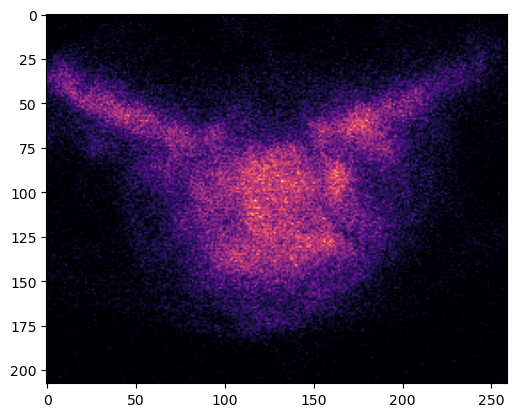

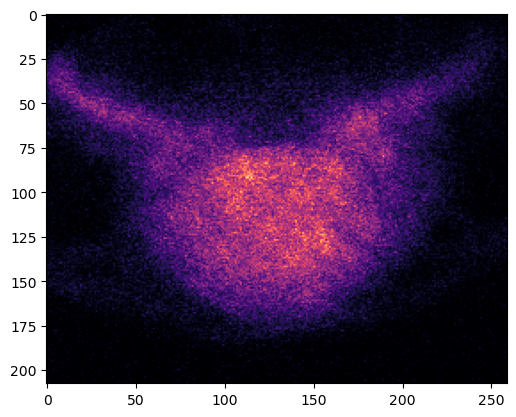

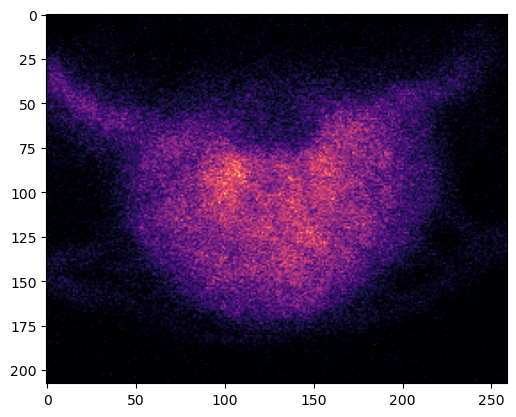

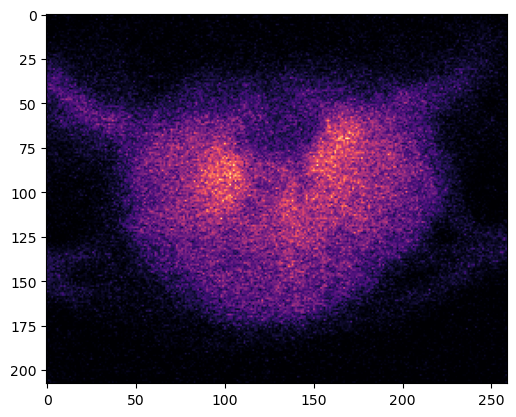

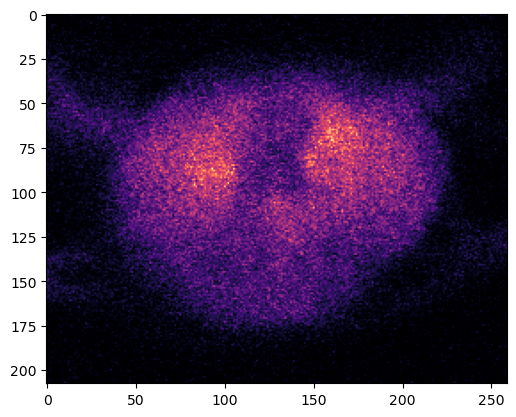

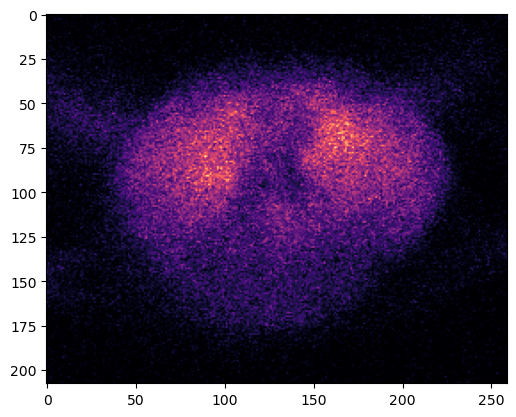

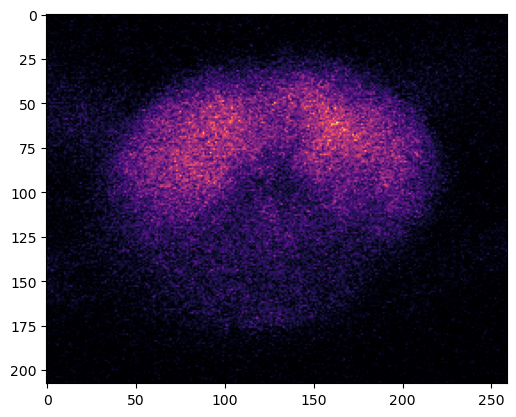

In [37]:
for z in range(7):
    fig, ax = plt.subplots()
    ax.imshow(stack[:,z,:,:].mean(axis=0), cmap='magma')
    
# fig, ax = plt.subplots()
# ax.imshow(np.amax(ref_img[2:,:,:],axis=0),cmap='magma')

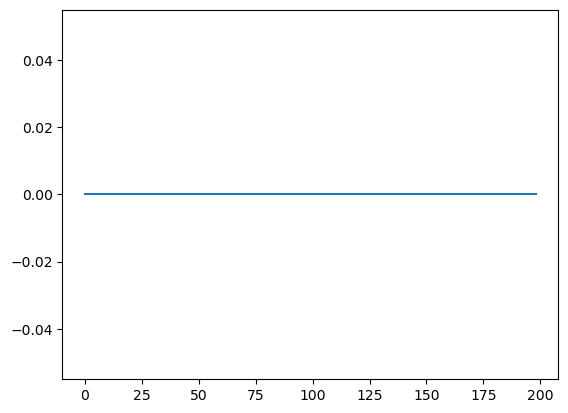

In [9]:
print(shift, error, diffphase)

[ 78.2 -31.9] 0.9999999998508202 -0.01315211686749414


In [43]:
# take a few segments of array

# take mean

# align each frame to mean

# take mean again

# align to get final reference

mu = test_stack[:200,:,:,:].mean(axis=0)
print(mu.shape)

(7, 208, 259)


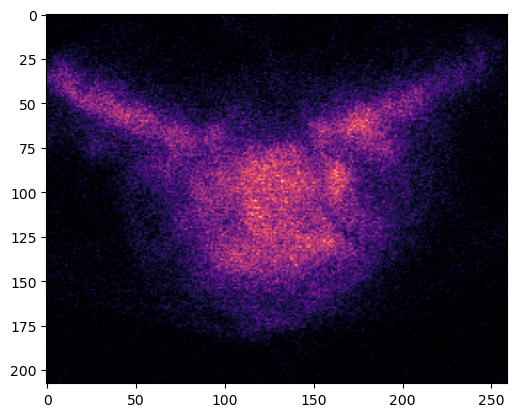

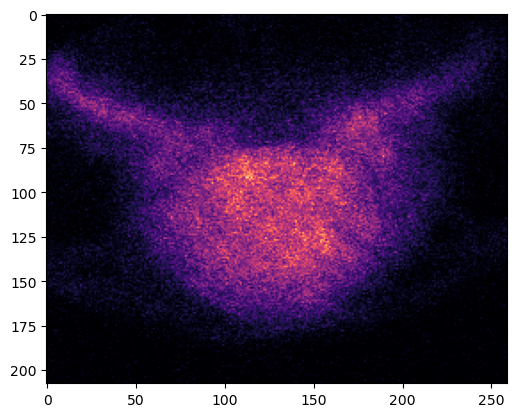

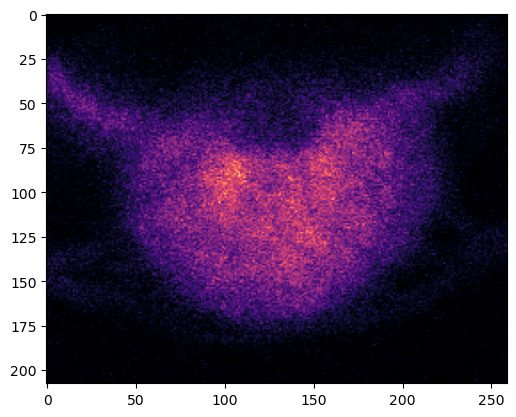

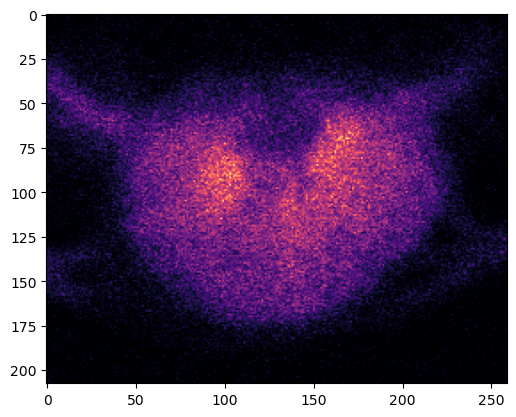

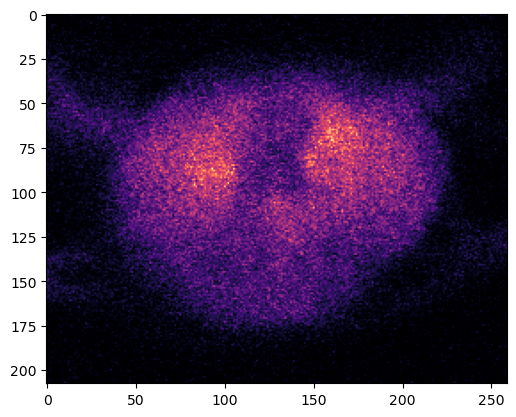

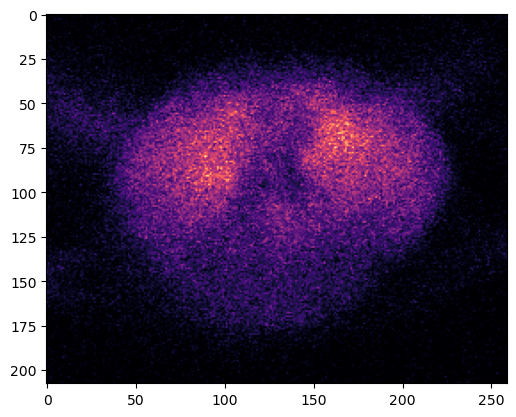

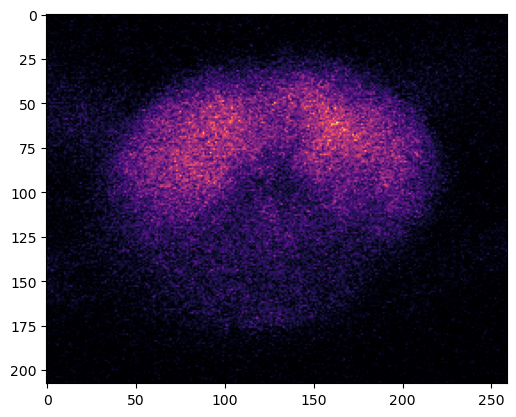

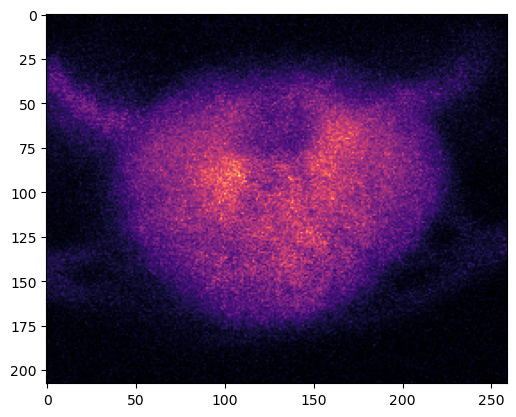

In [47]:
# fig, ax = plt.subplots()
for z in range(7):
    fig, ax = plt.subplots()
    ax.imshow(ref_img[z,:,:], cmap='magma')
    
fig, ax = plt.subplots()
ax.imshow(np.amax(ref_img[2:,:,:],axis=0),cmap='magma')

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

image = data.camera()

In [12]:
image = data.camera()
shift = (-22.4, 13.32)
# The shift corresponds to the pixel offset relative to the reference image
offset_image = fourier_shift(np.fft.fftn(image), shift)
offset_image = np.fft.ifftn(offset_image)
print(f'Known offset (y, x): {shift}')

# pixel precision first
shift, error, diffphase = phase_cross_correlation(image, offset_image, space='fourier')


Known offset (y, x): (-22.4, 13.32)


In [13]:
image.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False